In [1]:
import breakwater as bw
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read Input

1. Hydraulic input conditions
2. Damage levels

#### Provide path of input excel file

In [2]:
#Path excel file
path = 'Excel_Files/Input_Energy_Island.xlsx'

In [3]:
df_input_hydraulic = pd.read_excel(path, sheet_name= 'Hydraulic_Design_Conditions')
df_input_damage = pd.read_excel(path, sheet_name= 'Design_Requirements')

In [4]:
df_input_hydraulic.head(3)

,Case_ID,DIR (deg_N),Hm0(m),Tp(s),ReturnPeriod(YR),Design high water level (LAT+m),Design low water level (LAT+m)
0,1,0,3.9,10.4,1,2.41,0
1,2,45,4.2,9.1,1,2.41,0
2,3,90,3.4,7.3,1,2.41,0


In [5]:
df_input_damage.head(3)

,ReturnPeriod(YR),"Damage Rock Armour accepted, S (-)",Damage Toe accepted NoD (-),Overtopping accepted q (l/s/m)
0,1,2,0.5,1
1,5,2,0.5,10
2,10,2,0.5,10


#### Choose a return period

In [6]:
RP = 1000

In [7]:
df_input_hydraulic = df_input_hydraulic[df_input_hydraulic['ReturnPeriod(YR)'] == RP].reset_index()
df_input_damage = df_input_damage[df_input_damage['ReturnPeriod(YR)'] == RP].reset_index()

#### Wave conditions

In [8]:
df_input_hydraulic

,index,Case_ID,DIR (deg_N),Hm0(m),Tp(s),ReturnPeriod(YR),Design high water level (LAT+m),Design low water level (LAT+m)
0,48,49,0,8.4,13.2,1000,3.41,0
1,49,50,45,8.8,11.8,1000,3.41,0
2,50,51,90,6.7,9.1,1000,3.41,0
3,51,52,135,7.5,10.1,1000,3.41,0
4,52,53,180,10.0,13.0,1000,3.41,0
5,53,54,225,11.4,13.8,1000,3.41,0
6,54,55,270,12.8,15.8,1000,3.41,0
7,55,56,315,13.1,17.0,1000,3.41,0


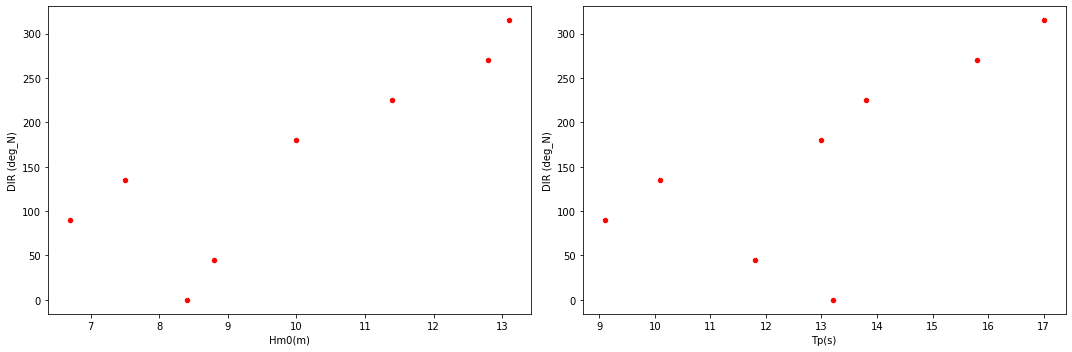

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

df_input_hydraulic.plot('Hm0(m)', 'DIR (deg_N)', color= 'r', kind= 'scatter', ax= ax1);
df_input_hydraulic.plot('Tp(s)', 'DIR (deg_N)', color= 'r', kind= 'scatter', ax= ax2);

fig.tight_layout()

#### Damage levels

In [10]:
df_input_damage

,index,ReturnPeriod(YR),"Damage Rock Armour accepted, S (-)",Damage Toe accepted NoD (-),Overtopping accepted q (l/s/m)
0,6,1000,4,3.0,100


In [11]:
Sd = df_input_damage['Damage Rock Armour accepted, S (-)'].values[0]
NoD = df_input_damage['Damage Toe accepted NoD (-)'].values[0]
q = df_input_damage['Overtopping accepted q (l/s/m)'].values[0]

## 3D shape

In [12]:
path = 'KML_files/Energy_Island_Shape.kml'

In [13]:
wave_conditions = {}

for index, row in df_input_hydraulic.iterrows():
    wave_conditions[row['DIR (deg_N)']] = {'Hm0': row['Hm0(m)'], 'Tp': row['Tp(s)']}
    
wave_conditions

{0.0: {'Hm0': 8.4, 'Tp': 13.2},
 45.0: {'Hm0': 8.8, 'Tp': 11.8},
 90.0: {'Hm0': 6.7, 'Tp': 9.1},
 135.0: {'Hm0': 7.5, 'Tp': 10.1},
 180.0: {'Hm0': 10.0, 'Tp': 13.0},
 225.0: {'Hm0': 11.4, 'Tp': 13.8},
 270.0: {'Hm0': 12.8, 'Tp': 15.8},
 315.0: {'Hm0': 13.1, 'Tp': 17.0}}

In [14]:
# create a rock grading, give correct values for M50, NLL and NUL

def Non_standard_grading(NLL, NUL, rho_s = 2650, A = {'min': 0.663, 'max': 1.515}, 
                         B = {'min': 1.041, 'max': 0.959}, fine = False):
    """
    
    Calculate the M50_emll and the M50_umul for non-standard gradings
    
    Parameters
    -------------
    NLL: int
        Nominal Lower Limit of the grading
    NULL int
        Nominal Upper Limit of the grading
    A: dict
        Coefficient upper and lower
    B: float
        Coefficient upper and lower
        
    returns
    -----------
    tuple
    
    """
    
    if not fine:
        M50 = (NLL + NUL) / 2
        M50_emll = A['min'] * M50 ** B['min']
        M50_umul = A['max'] * M50 ** B['max']
        return (M50_emll, M50_umul)
    
    else:
        NLL = 2650 * (NLL/1000)**3
        NUL = 2650 * (NUL/1000)**3
        M50 = (NLL + NUL) / 2
        M50_emll = A['min'] * M50 ** B['min']
        M50_umul = A['max'] * M50 ** B['max']
        return (NLL, NUL, M50_emll, M50_umul)

# fine gradings
NLL_0_200mm, NUL_0_200mm, M50_emll_0_200mm, M50_umul_0_200mm = Non_standard_grading(NLL = 1, NUL = 200, fine= True)
NLL_0_300mm, NUL_0_300mm, M50_emll_0_300mm, M50_umul_0_300mm = Non_standard_grading(NLL = 1, NUL = 300, fine= True)

# coarse gradings
M50_emll_8_12t, M50_umul_8_12t = Non_standard_grading(NLL = 8000, NUL = 12000)
M50_emll_10_13t, M50_umul_10_13t = Non_standard_grading(NLL = 10000, NUL = 13000)

Grading_EI = {
               '0-200mm':
                   {'M50': [M50_emll_0_200mm, M50_umul_0_200mm], 'NLL': NLL_0_200mm, 'NUL': NLL_0_300mm},
               '0-300mm':
                   {'M50': [M50_emll_0_300mm, M50_umul_0_300mm], 'NLL': NLL_0_300mm, 'NUL': NUL_0_300mm},
               '60-300kg':
                   {'M50': [45, 135], 'NLL': 15, 'NUL': 300},
               '300-1000kg':
                   {'M50': [540, 690], 'NLL': 300, 'NUL': 1000},
               '1-3t':
                   {'M50': [1700, 2100], 'NLL': 1000, 'NUL': 3000},
               '3-6t':
                   {'M50': [4200, 4800], 'NLL': 3000, 'NUL': 6000},
               '8-12t':
                   {'M50': [M50_emll_8_12t, M50_umul_8_12t], 'NLL': 8000, 'NUL': 12000},
               '10-13t':
                   {'M50': [M50_emll_10_13t, M50_umul_10_13t], 'NLL': 10000, 'NUL': 13000}
              }

Grading = bw.RockGrading(grading= Grading_EI)

In [15]:
# create cubipod armour units

def Cubipod_units(masses, rho_c = 2400, n = 1):
    
    """
    Function to create Cubipods from list of masses
    
    Parameters
    -------------
    masses: lst
        list of the masses in tons
    rho_c: int
        density of the concrete in kg/m3
    n: int
        number of layers
    
    returns
    -----------
    dict
    
    """
    
    units = {}
    for m in masses:
        V = m / rho_c * 1000
        Dn = V ** (1/3)
        h = n * Dn
        rho_placement = 100 / (Dn**2 / 0.59)
        Vc = (V * rho_placement) / 100
        V, Dn, h, Vc = round(V, 2), round(Dn, 2), round(h, 2), round(Vc, 2)
        units[V] = {"D": Dn, "h": h, "Vc": Vc, 'M': f'{m}t'}
        
    return units
        
        
        
units = Cubipod_units(masses = [28, 35, 41, 50, 55, 65, 95, 150, 230])


Cubipod = bw.ConcreteArmour(
                            kd=12,
                            name="Cubipods",
                            units=units,
                            )

In [16]:
battjes_3D = bw.BattjesGroenendijk_3D(h = 27, wave_conditions= wave_conditions, slope_foreshore= (1, 100))

H2_3D = battjes_3D.get_Hp(0.02)

ULS_3D = bw.LimitState_3D(h= 27, wave_conditions= wave_conditions, H2_per = H2_3D, Sd= 4, Nod= 5, q= 100, label= 'uls')

ULS_3D.transform_periods(0.5)

In [17]:
EI_3D = bw.structure_3D(
                        kml_path= path,
                        wave_direction= 'right',
                        wave_conditions= wave_conditions,
                        shape= 'Linestring',
                        structure_type= 'revetment',
                        slope= (2,3),
                        slope_foreshore= (1,100),
                        rho_w= 1025,
                        B= 5,
                        N= 2600,
                        LimitState= ULS_3D,
                        ArmourUnit= Cubipod,
                        Grading= Grading,
                        core_material = {'class': 'QR 1-1000kg', 'Dn50': 0.45},
                        filter_rule = 'XblocPlus'
                        )

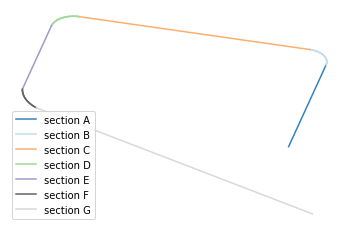

In [18]:
EI_3D.plot_topview()

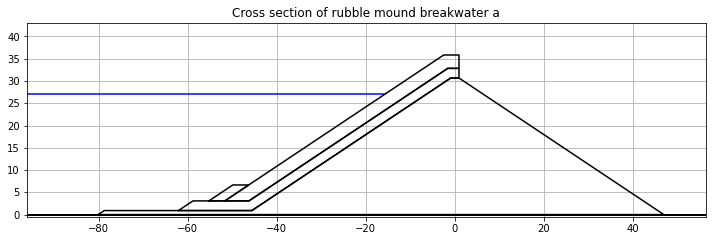

In [19]:
EI_3D.plot_section('a', section= ('section A', 0))

In [20]:
# Water levels LAT

MHW = 27 + 0.51 
MSL = 27 + 0.32
MLW = 27 + 0.17

In [21]:
dumptruck = bw.Truck(name = 'dumptruck',
                     design_type = {'0-300mm': {'cost': 16, 'CO2': None, 'production_rate':  15713.88},
                                    'QR 1-1000kg': {'cost': 16, 'CO2': None, 'production_rate':  16197.39}},
                     waterlvl = MHW,
                     h_dry = 2,
                     required_length= 5
                    )

Hit1200 = bw.HITACHI_EX1200(name = 'Hit1200',
                            design_type = {'3-6t': {'cost': 56, 'CO2': None, 'production_rate':  6963.16}},
                            waterlvl = MHW,
                            h_dry = 2,
                            required_length= 4
)

Hit1900 = bw.HITACHI_EX1900(name = 'Hit1900',
                            design_type = {'1-3t': {'cost': 56, 'CO2': None, 'production_rate':  6963.16},
                                           '3-6t': {'cost': 56, 'CO2': None, 'production_rate':  6963.16},
                                           '8-12t': {'cost': 57, 'CO2': None, 'production_rate':  8355.80},
                                           '10-13t': {'cost': 57, 'CO2': None, 'production_rate':  7687.33},
                                           '28t': {'cost': 57, 'CO2': None, 'production_rate': 14043.08}},
                            waterlvl = MHW,
                            h_dry = 2,
                            required_length= 5
)

equipment = [dumptruck, Hit1200, Hit1900]

In [22]:
rock_procurement = {
                     '0-200mm': {'cost': 9, 'CO2': 9.55*10**-6}, 
                     '0-300mm': {'cost': 9, 'CO2': 9.55*10**-6}, 
                     '60-300kg': {'cost': 12, 'CO2': 9.25*10**-6}, 
                     '300-1000kg': {'cost': 12, 'CO2': 3.6*10**-5}, 
                     '1-3t': {'cost': 12, 'CO2': 3.6*10**-5}, 
                     '3-6t': {'cost': 14, 'CO2': 3.6*10**-5}, 
                     '8-12t': {'cost': 20, 'CO2': 3.6*10**-5}, 
                     '10-13t': {'cost': 25, 'CO2': 3.6*10**-5}
                    }


Cubipod_procurement = {
                        11.67: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        14.58: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        17.08: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        20.83: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        22.92: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        27.08: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        39.58: {'cost': 105.51, 'CO2': 1.46*10**-4},
                        62.5: {'cost': 105.51 + 20.83, 'CO2': 1.46*10**-4},
                        95.83: {'cost': 105.51 + 20.83, 'CO2': 1.46*10**-4},
                        }

In [23]:
df_material_cost = EI_3D.totalcost_3D(
                                       core_price= {'cost': 11, 'CO2': 9*10**-6}, 
                                       grading_price= rock_procurement, 
                                       unit_price= Cubipod_procurement
                                      )

In [24]:
df_material_cost

structure  length [m]  \
section A 0   id.None: breakwater with armour units as armou...         267   
section B 0   id.None: breakwater with armour units as armou...           2   
          1   id.None: breakwater with armour units as armou...           2   
          2   id.None: breakwater with armour units as armou...           2   
          3   id.None: breakwater with armour units as armou...           2   
...                                                         ...         ...   
section F 20  id.None: breakwater with armour units as armou...           3   
          21  id.None: breakwater with armour units as armou...           3   
          22  id.None: breakwater with armour units as armou...           3   
          23  id.None: breakwater with armour units as armou...           3   
section G 0   id.None: breakwater with armour units as armou...         591   

                                            material cost [EUR]  \
section A 0   {'a': 10038221.55, 'b': 10065745.49, 'c': 1023...   
section B 0   {'a': 75063.57, 'b': 75269.43, 'c': 76519.11, ...   
          1   {'a': 74805.66, 'b': 75010.89, 'c': 76257.29, ...   
          2   {'a': 74676.86, 'b': 74881.78, 'c': 76126.53, ...   
          3   {'a': 74676.86, 'b': 74881.78, 'c': 76126.53, ...   
...                                                         ...   
section F 20   {'a': 163300.61, 'b': 165848.85, 'c': 166424.69}   
          21   {'a': 163300.61, 'b': 165848.85, 'c': 166424.69}   
          22   {'a': 163300.61, 'b': 165848.85, 'c': 166424.69}   
          23   {'a': 172444.37, 'b': 175078.09, 'c': 175683.38}   
section G 0   {'a': 33307125.88, 'b': 33817176.5, 'c': 33936...   

                                             material CO2 [kge]  
section A 0   {'a': 12.1381, 'b': 13.256, 'c': 13.3694, 'd':...  
section B 0   {'a': 0.0908, 'b': 0.0991, 'c': 0.1, 'd': 0.1032}  
          1   {'a': 0.0905, 'b': 0.0989, 'c': 0.0997, 'd': 0...  
          2   {'a': 0.0904, 'b': 0.0987, 'c': 0.0996, 'd': 0...  
          3   {'a': 0.0904, 'b': 0.0987, 'c': 0.0996, 'd': 0...  
...                                                         ...  
section F 20            {'a': 0.1932, 'b': 0.1987, 'c': 0.1934}  
          21            {'a': 0.1932, 'b': 0.1987, 'c': 0.1934}  
          22            {'a': 0.1932, 'b': 0.1987, 'c': 0.1934}  
          23             {'a': 0.2028, 'b': 0.2083, 'c': 0.203}  
section G 0          {'a': 39.2417, 'b': 40.3221, 'c': 39.2869}  

[118 rows x 4 columns]

In [25]:
# df_total_cost = EI_3D.totalcost_3D(
#                                    equipment= equipment,
#                                    core_price= {'cost': 11, 'CO2': 9*10**-6}, 
#                                    grading_price= rock_procurement, 
#                                    unit_price= Cubipod_procurement
#                                   )

In [26]:
# df_total_cost